### Constants

In [2]:
DEPARTURE = 'LEMD'
DESTINATION = 'LEBL'

FLIGHTS_PATH = 'data/flights'
FLIGHTS_POINTS_PATH = 'data/flight_points'

METHOD = 'davies_bouldin'
GRAPHS_PATH = f'results/graphs/single-trajectory/{METHOD}'

In [3]:
from src.pipeline import build_pipeline

data_pipeline = build_pipeline(flights_path = FLIGHTS_PATH, 
                               flights_points_path = FLIGHTS_POINTS_PATH, 
                               departure = DEPARTURE, 
                               destinations = [DESTINATION])

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

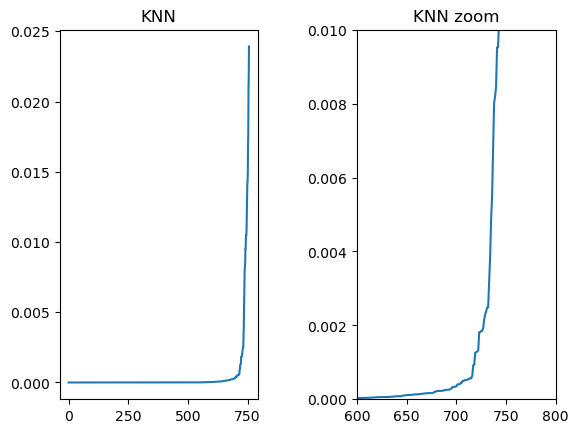

In [16]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([600, 800, 0, 0.01])

plt.savefig(f'{GRAPHS_PATH}/elbow_sspd.png', dpi=600, bbox_inches='tight')

In [17]:
import numpy as np
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.arange(0.001, 0.015, 0.001),
  "min_samples": np.arange(3, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                              params  clusters  outliers   
0    {'eps': 0.014000000000000002, 'min_samples': 4}         3        16  \
1    {'eps': 0.014000000000000002, 'min_samples': 5}         3        16   
2    {'eps': 0.014000000000000002, 'min_samples': 6}         3        16   
3    {'eps': 0.014000000000000002, 'min_samples': 7}         3        16   
4    {'eps': 0.014000000000000002, 'min_samples': 8}         3        16   
5    {'eps': 0.014000000000000002, 'min_samples': 9}         3        16   
6   {'eps': 0.014000000000000002, 'min_samples': 10}         3        16   
7   {'eps': 0.014000000000000002, 'min_samples': 11}         3        16   
8   {'eps': 0.014000000000000002, 'min_samples': 12}         3        16   
9   {'eps': 0.014000000000000002, 'min_samples': 13}         3        16   
10  {'eps': 0.014000000000000002, 'min_samples': 14}         3        16   
11  {'eps': 0.014000000000000002, 'min_samples': 15}         3        16   
12   {'eps':

In [18]:
from importlib import reload
import utils.graphs
reload(utils.graphs)

<module 'utils.graphs' from '/Users/rodrigo/Proyectos/TFM/utils/graphs.py'>

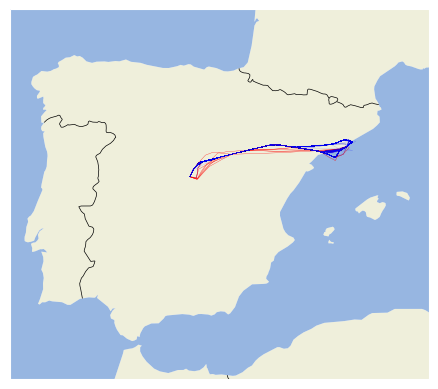

In [19]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
best_estimator = search["best_estimator_"]
params = best_estimator["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, 
                  clusterer.labels_, 
                  f'{GRAPHS_PATH}/outliers_sspd_dbscan.png')

### HDBSCAN

In [20]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                          params  clusters  outliers   
0    {'min_samples': 4, 'min_cluster_size': 120}         3        13  \
1    {'min_samples': 4, 'min_cluster_size': 140}         3        13   
2    {'min_samples': 5, 'min_cluster_size': 120}         3        13   
3    {'min_samples': 5, 'min_cluster_size': 140}         3        13   
4    {'min_samples': 6, 'min_cluster_size': 120}         3        13   
5    {'min_samples': 6, 'min_cluster_size': 140}         3        13   
6    {'min_samples': 7, 'min_cluster_size': 120}         3        13   
7    {'min_samples': 7, 'min_cluster_size': 140}         3        13   
8    {'min_samples': 8, 'min_cluster_size': 120}         3        13   
9    {'min_samples': 8, 'min_cluster_size': 140}         3        13   
10   {'min_samples': 9, 'min_cluster_size': 120}         3        13   
11   {'min_samples': 9, 'min_cluster_size': 140}         3        13   
12  {'min_samples': 10, 'min_cluster_size': 120}         3      

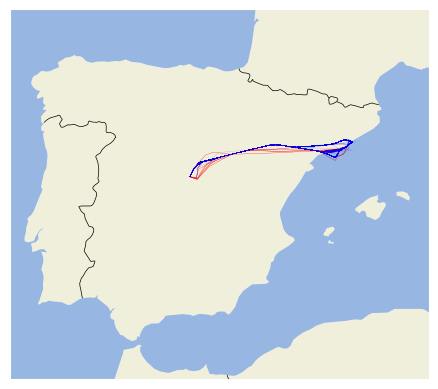

In [21]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

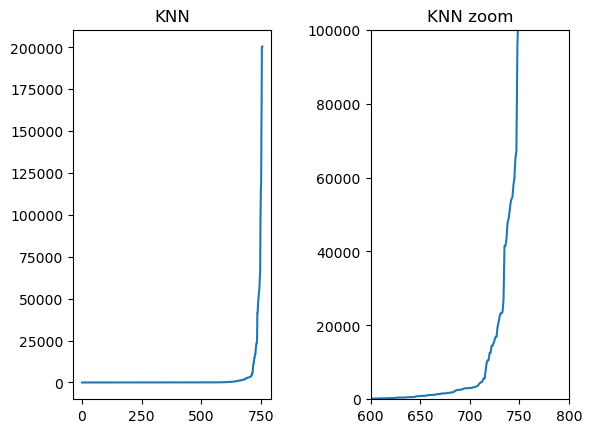

In [22]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([600, 800, 0, 100000])

plt.savefig(f'{GRAPHS_PATH}/elbow_erp.png', dpi=600, bbox_inches='tight')

In [23]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.arange(10000, 100000, 10000),
  "min_samples": np.arange(1, 5)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                              params  clusters  outliers     noise   
0   {'eps': 30000, 'min_samples': 1}        30         0  0.000000  \
1   {'eps': 40000, 'min_samples': 1}        29         0  0.000000   
2   {'eps': 60000, 'min_samples': 1}        17         0  0.000000   
3   {'eps': 20000, 'min_samples': 1}        37         0  0.000000   
4   {'eps': 50000, 'min_samples': 1}        24         0  0.000000   
5   {'eps': 10000, 'min_samples': 1}        49         0  0.000000   
6   {'eps': 70000, 'min_samples': 1}        15         0  0.000000   
7   {'eps': 80000, 'min_samples': 1}        15         0  0.000000   
8   {'eps': 90000, 'min_samples': 1}        15         0  0.000000   
9   {'eps': 20000, 'min_samples': 3}         7        34  4.491413   
10  {'eps': 20000, 'min_samples': 4}         6        37  4.887715   
11  {'eps': 70000, 'min_samples': 4}         6        12  1.585205   
12  {'eps': 80000, 'min_samples': 4}         6        12  1.585205   
13  {'eps': 90000, '

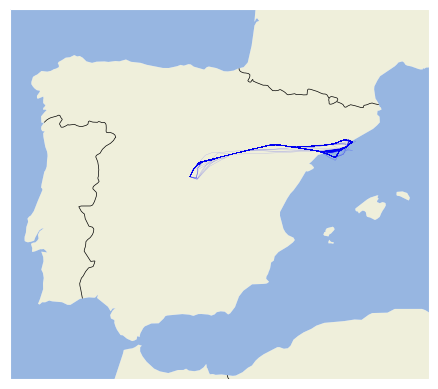

In [24]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_dbscan.png')

### HDBSCAN

In [25]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(erp_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))


                                         params  clusters  outliers     noise   
0    {'min_samples': 1, 'min_cluster_size': 40}         5        47  6.208719  \
1    {'min_samples': 1, 'min_cluster_size': 60}         5        47  6.208719   
2    {'min_samples': 1, 'min_cluster_size': 80}         5        47  6.208719   
3    {'min_samples': 2, 'min_cluster_size': 40}         5        49  6.472919   
4    {'min_samples': 2, 'min_cluster_size': 60}         5        49  6.472919   
5    {'min_samples': 2, 'min_cluster_size': 80}         5        49  6.472919   
6    {'min_samples': 3, 'min_cluster_size': 40}         5        49  6.472919   
7    {'min_samples': 3, 'min_cluster_size': 60}         5        49  6.472919   
8    {'min_samples': 3, 'min_cluster_size': 80}         5        49  6.472919   
9    {'min_samples': 4, 'min_cluster_size': 40}         5        51  6.737120   
10   {'min_samples': 4, 'min_cluster_size': 60}         5        51  6.737120   
11   {'min_samples': 4, 'min

{'params': {'min_samples': 1, 'min_cluster_size': 40}, 'clusters': 5, 'outliers': 47, 'noise': 6.208718626155878, 'method': 'davies_bouldin', 'score': 0.6197598854985182}


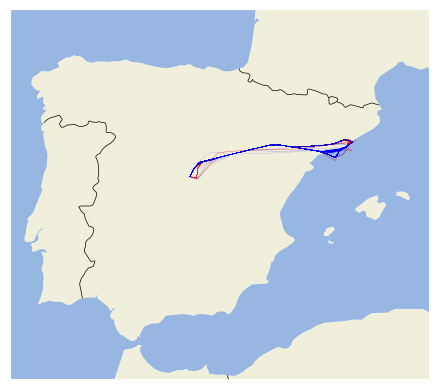

In [27]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_hdbscan.png')